In [39]:
## The Hyperparametes
EPOCH = 10                
batch_size = 4
LR = 0.001

In [40]:
## Libaries
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import time
from datetime import datetime
time_date = datetime.now()
date = time_date.strftime("%d/%m/%Y")
Time = time_date.strftime("%H:%M:%S")

In [41]:
## ToTensor & Download the Dataset
transform =  transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(3, 1, 1)), transforms.Resize(256),
    transforms.CenterCrop(224)])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train = False, transform=transform)

## to DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')

shape of images torch.Size([3, 224, 224])


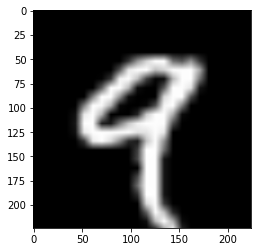

In [42]:
## check 
print('shape of images', trainset[0][0].shape)
plt.imshow(trainset[4][0][0], cmap='gray');

In [43]:
## Taking the effect of CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
## Now using the VGG16
VGG16_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=False, num_classes=10)
## Model description -- summary


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [45]:
## Validation 
def calculate_accuracy(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)

    return correct*100./total

In [46]:
## Intialize a Model
## Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Verifying CUDA
print(device)

## Move the input and AlexNet_model to GPU for speed if available
net = VGG16_model.to(device)

cuda:0


In [47]:
## Traing and Validate in one function as MNIST has one channel
def train():
    print("---------------------------------------------------")
    print("Model Training and Testing Start date:", date)
    print("Model Training and Testing starting time:", Time)
    print("---------------------------------------------------")
    print('vgg16 Training and Testing Begins!')
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    max_accuracy=0

    train_accuracies = []
    validation_accuracies = []
    
    train_losses = []
    validation_losses = []
    
    for epoch in range(EPOCH):
        ep_start = time.time()
        ## training loop
        train_loss = 0
        for i, (images,labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_item = loss.item()
            train_loss += loss_item * images.size(0)
            loss.backward()
            optimizer.step()


        ## validation loop
        valid_loss = 0.0
        net.eval()     # Optional when not using Model Specific layer
        for data, labels in testloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            target = net(data)
            loss = criterion(target,labels)
            valid_loss += loss.item() * data.size(0)

        train_losses.append(train_loss)  
        validation_losses.append(valid_loss)

        valid_accuracy = float(calculate_accuracy(net, testloader))
        
        train_accuracy = float(calculate_accuracy(net, trainloader))
        
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(valid_accuracy)

        Start_Time=datetime.now()
        
        print(f'Epoch {epoch+1} \t\t Train Acc: {train_accuracy} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(testloader)} \t\t validation Acc: {valid_accuracy} \t\t Time Duration {time.time() - ep_start}:')
        # print("Epoch %d accuracy: %f loss: %f" % (epoch, accuracy, loss_item))
        if valid_accuracy > max_accuracy:
            best_model = copy.deepcopy(criterion)
            max_accuracy = valid_accuracy
            print("Saving Best Model with Accuracy: ", valid_accuracy)
        print('Epoch:', epoch+1, "Accuracy :", valid_accuracy, '%')
    # plt.plot(accuracies)
    history = {'train_losses' : [train_loss / len(trainloader) for train_loss in train_losses], 'train_accuracy' : train_accuracies, 'validation_losses' : [valid_loss / len(testloader) for valid_loss in validation_losses], 'validation_accuracy' : validation_accuracies}
    End_Time=datetime.now()
    end_date = End_Time.strftime("%d/%m/%Y")
    end_time = End_Time.strftime("%H:%M:%S")
    print('vgg16 Training and Testing Completed!')
    print("--------------------------------------------------")
    print("Model Training and Testing End date:", end_date)
    print("Model Training and Testing End time:", end_time)    
    return best_model, history


In [48]:
## Call the function to start training
vgg, history = train()

---------------------------------------------------
Model Training and Testing Start date: 15/05/2022
Model Training and Testing starting time: 16:01:18
---------------------------------------------------
vgg16 Training and Testing Begins!
Epoch 1 		 Train Acc: 98.80000305175781 		 Training Loss: 0.675950352141368 		 Validation Loss: 0.13517088442620234 		 validation Acc: 98.87000274658203 		 Time Duration 1187.0517807006836:
Saving Best Model with Accuracy:  98.87000274658203
Epoch: 1 Accuracy : 98.87000274658203 %
Epoch 2 		 Train Acc: 99.44000244140625 		 Training Loss: 0.13976519061685674 		 Validation Loss: 0.10312872235728958 		 validation Acc: 99.1500015258789 		 Time Duration 1149.2568209171295:
Saving Best Model with Accuracy:  99.1500015258789
Epoch: 2 Accuracy : 99.1500015258789 %
Epoch 3 		 Train Acc: 99.28500366210938 		 Training Loss: 0.08445251802208109 		 Validation Loss: 0.11957713160626776 		 validation Acc: 99.12999725341797 		 Time Duration 1144.207764863968:
Epoch:

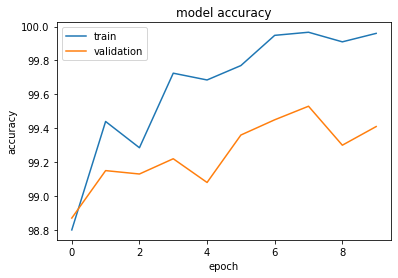

In [49]:
#  "Accuracy"
plt.plot(history['train_accuracy'])
plt.plot(history['validation_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


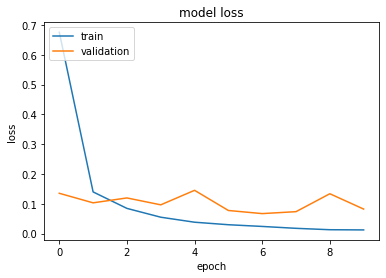

In [50]:
# "Loss"
plt.plot(history['train_losses'])
plt.plot(history['validation_losses'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
## Testing classification accuracy for individual classes. -- also it is useful if you want it
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
